# Earthquakes on IRIS

This notebooks demonstrate how to search and display earthquate events, network, stations that record the events via IRIS using Obspy. 

* Searth events via IRIS data service 
* Plot waveforms
* Show station metadata
* Remove instrument response
   
---------

- Authors: NCI Virtual Research Environment Team
- Keywords: earthquake, geophysics
- Create Date: 2020-Sep
---

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
%matplotlib inline

ObsPy has clients to directly fetch data via...

- FDSN webservices (IRIS, Geofon/GFZ, USGS, NCEDC, SeisComp3 instances, ...)
- ArcLink (EIDA, ...)
- Earthworm
- SeedLink (near-realtime servers)
- NERIES/NERA/seismicportal.eu
- NEIC
- SeisHub (local seismological database)

This introduction shows how to use the FDSN webservice client. The FDSN webservice definition is by now the default web service implemented by many data centers world wide. Clients for other protocols work similar to the FDSN client.

#### Find data

Let's find a large earthquake in Australia from IRIS data service website: http://ds.iris.edu/wilber3/find_event

Pick up event with M6.0+ since 1990. Put geographic bounding box around Australia and its surounding areas. There is an event occurred on the 20th of May, 2016 in NT, Australia , highlighted in green (see below). 

![](images/IRIS_event_search.png)

**Click that event, stations that recorded this event are shown on the webpage.**

![](images/IRIS_event_stations.png)

**From this page, seismic waveforms around this events can be extracted and shown by clicking each station name.**

![](images/IRIS_event_Tennant_creek.png)

**Information about network, station, channels, etc are shown on this page.**

#### FDSN client search

Users can search for large earthquakes in Australia and its surounding areas in the past 10 years by calling `.get_events()` method. Use `?` to help you with all available arguments.

In [2]:
client.get_events?

Object `client.get_events` not found.


2 Event(s) in Catalog:
2019-07-14T05:39:23.427000Z | -18.224, +120.357 | 6.6 Mww
2016-05-20T18:14:04.670000Z | -25.566, +129.884 | 6.0 Mww


/g/data/dk92/admin/testing/NCI-data-analysis_2021.06_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/g/data/dk92/admin/testing/NCI-data-analysis_2021.06_py38/lib/python3.8/site-packages/obspy/imaging/maps.py:303: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(


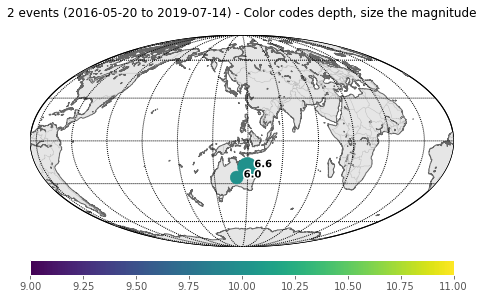

Event:	2019-07-14T05:39:23.427000Z | -18.224, +120.357 | 6.6 Mww

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=11073569")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=40068586")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=195274078")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


In [4]:
from obspy.clients.fdsn import Client

client = Client("IRIS")
catalog = client.get_events(starttime="2010-01-01",
                            endtime="2020-01-01",
                            minmagnitude=6, 
                            minlatitude=-44,
                            maxlatitude=-15,
                            minlongitude=110,
                            maxlongitude=150)
print(catalog)
catalog.plot()
event = catalog[0]
print(event)

- search for stations to look at waveforms for the event. stations should..
    * be available at the time of the event
    * use a vertical 1 Hz stream ("LHZ", to not overpower our network..)
    * be in a narrow angular distance around the event (e.g. 90-91 degrees)
    * adjust your search so that only a small number of stations (e.g. 3-6) match your search criteria
    * Once you found a good set of stations, please use `level="response"` as you will need the response later on.

Now let's find out station information using `.get_stations()` method.

In [5]:
origin = event.origins[0]
t = origin.time

inventory = client.get_stations(longitude=origin.longitude, latitude=origin.latitude,
                                minradius=101, maxradius=103,
                                starttime=t, endtime =t+100,
                                channel="BHZ", level="response",
                                matchtimeseries=True)
print(inventory)

Inventory created at 2021-04-16T07:02:35.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2019-07-14...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (5):
			AK, AV, II, KO, TA
		Stations (57):
			AK.CHI (Chirikof Island, AK, USA)
			AK.RDOG (Red Dog Mine, AK, USA)
			AK.SII (Sitkinak Island Coast Guard, AK, USA)
			AV.ACH (Angle Creek Headwaters, Katmai, Alaska)
			AV.ANCK (Angle Creek, Katmai Volcanic Cluster, Alaska)
			AV.CAHL (Cahill, Katmai, Alaska)
			AV.KABU (KABU - Katmai Volcanic Cluster, Alaska)
			AV.KAHG (Katmai Hook Glacier, Alaska)
			AV.KAKN (KAKN - Katmai Volcanic Cluster, Alaska)
			AV.KJL (Kejulik, Katmai, Alaska)
			AV.PLBL (Mt. Peulik Volcano, Alaska)
			AV.PLK1 (Peulik Volcano 1, Alaska)
			AV.PLK2 (Mt. Peulik Volcano 2, Alaska)
			AV.PLK3 (Mt. Peulik Volcano 3, Alaska)
			AV.PLK5 (Mt. Peulik Volcano 5, Alaska)
			II.OBN (Obninsk, Russia)
			KO.ELL (Elmali-Antal

#### Extract data 

Seismograms of various formats (e.g. SAC, MiniSEED, GSE2, SEISAN, Q, etc.) can be imported into a Stream object in obspy.

Streams are list-like objects which contain multiple Trace objects, i.e. gap-less continuous time series and related header/meta information. Each Trace object has a attribute called data pointing to a NumPy ndarray of the actual time series and the attribute stats which contains all meta information in a dictionary-like Stats object. Both attributes starttime and endtime of the Stats object are UTCDateTime objects.

In [6]:
import obspy
from obspy.clients.fdsn import Client

client = Client("IRIS")
t = obspy.UTCDateTime("2016-05-20T18:14:04") # NT event Mww6.0
st = client.get_waveforms("II","WRAB","00","BH*", t - 5 * 60, t + 20 * 60)
print(st)

3 Trace(s) in Stream:
II.WRAB.00.BH1 | 2016-05-20T18:09:04.019538Z - 2016-05-20T18:34:03.969538Z | 20.0 Hz, 30000 samples
II.WRAB.00.BH2 | 2016-05-20T18:09:04.019538Z - 2016-05-20T18:34:03.969538Z | 20.0 Hz, 30000 samples
II.WRAB.00.BHZ | 2016-05-20T18:09:04.019538Z - 2016-05-20T18:34:03.969538Z | 20.0 Hz, 30000 samples


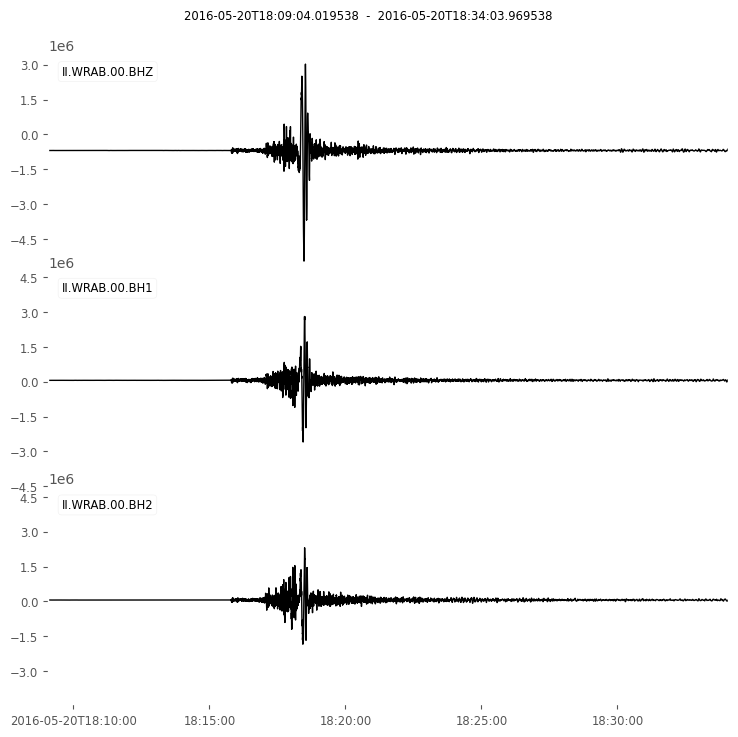

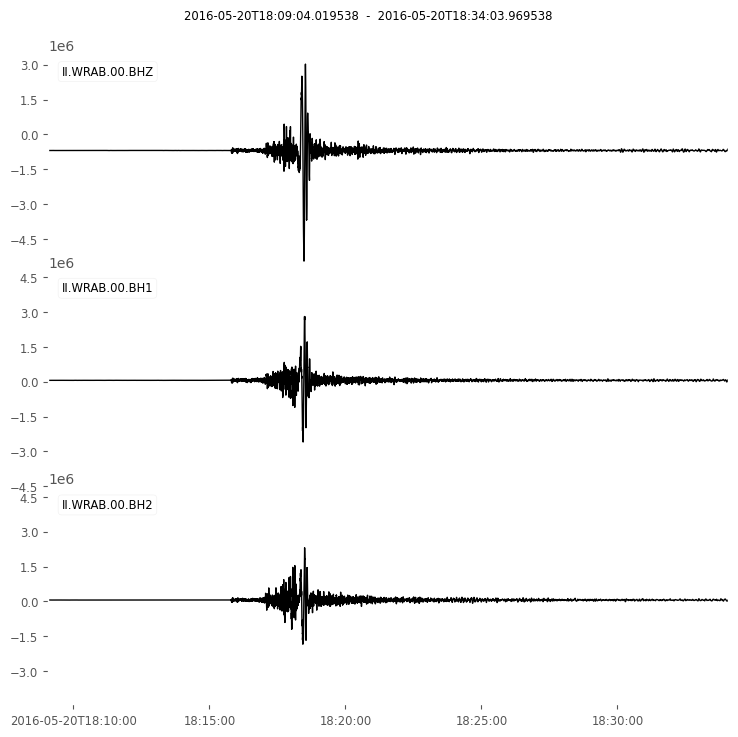

In [7]:
# print out the waveform
st.plot()

#### Event Metadata

The FDSN client can also be used to request event metadata:

1 Event(s) in Catalog:
2016-05-20T18:14:04.670000Z | -25.566, +129.884 | 6.0 Mww


/g/data/dk92/admin/testing/NCI-data-analysis_2021.06_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


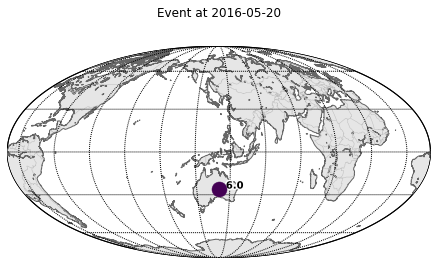

In [8]:
t = obspy.UTCDateTime("2016-05-20T18:14:04")  # NT event Mww6.0
catalog = client.get_events(starttime=t - 100, endtime=t + 3600,
                            minmagnitude=6)
print(catalog)
catalog.plot();

Requests can have a wide range of constraints (see [ObsPy Documentation](http://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html)):

- time range
- geographical (lonlat-box, circular by distance)
- depth range
- magnitude range, type
- contributing agency

#### Station Metadata

Finally, the FDSN client can be used to request station metadata. Stations can be looked up using a wide range of constraints (see [ObsPy documentation](http://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html)):

 * network/station code
 * time range of operation
 * geographical (lonlat-box, circular by distance)

Inventory created at 2021-04-16T07:05:13.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2021-04-16...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (3):
			AU, S1, SY
		Stations (5):
			AU.PHB (Parliment House Basement - Canberra)
			S1.AUDAR (Daramalan College)
			S1.AUSIS (Australian National Universtiy)
			SY.AUDAR (AUDAR synthetic)
			SY.AUSIS (AUSIS synthetic)
		Channels (0):



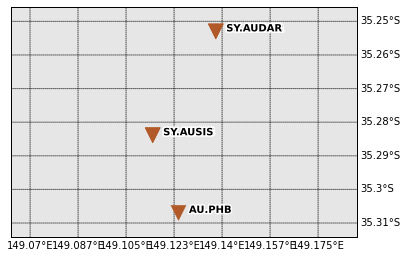

In [10]:
event = catalog[0]
origin = event.origins[0]

# Canberra
lon = 149.113
lat = -35.28

# Get currently active stations in 5 km radius around Livermore.
inventory = client.get_stations(longitude=lon, latitude=lat,
                                maxradius=0.05, level="station", 
                                starttime=obspy.UTCDateTime())
print(inventory)
inventory.plot(projection="local", resolution="i");

The **`level=...`** keyword is used to specify the level of detail in the requested inventory

- `"network"`: only return information on networks matching the criteria
- `"station"`: return information on all matching stations
- `"channel"`: return information on available channels in all stations networks matching the criteria
- `"response"`: include instrument response for all matching channels (large result data size!)

In [11]:
inventory = client.get_stations(network="II", station="WRAB",
                                level="station")
print(inventory)

Inventory created at 2021-04-16T07:05:17.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?network=II&station=W...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			II
		Stations (1):
			II.WRAB (Tennant Creek, NT, Australia)
		Channels (0):



In [12]:
inventory = client.get_stations(network="II", station="WRAB",
                                level="channel")
print(inventory)

Inventory created at 2021-04-16T07:05:19.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?network=II&station=W...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			II
		Stations (1):
			II.WRAB (Tennant Creek, NT, Australia)
		Channels (247):
			II.WRAB.00.BHZ (10x), II.WRAB.00.BHN (6x), II.WRAB.00.BHE (6x), 
			II.WRAB.00.BH1 (4x), II.WRAB.00.BH2 (4x), II.WRAB.00.ENZ (2x), 
			II.WRAB.00.EN1 (2x), II.WRAB.00.EN2 (2x), II.WRAB.00.LCE, 
			II.WRAB.00.LCQ, II.WRAB.00.LDI (3x), II.WRAB.00.LHZ (10x), 
			II.WRAB.00.LHN (6x), II.WRAB.00.LHE (6x), II.WRAB.00.LH1 (4x), 
			II.WRAB.00.LH2 (4x), II.WRAB.00.LNZ (2x), II.WRAB.00.LN1 (2x), 
			II.WRAB.00.LN2 (2x), II.WRAB.00.VHZ (10x), II.WRAB.00.VHN (6x), 
			II.WRAB.00.VHE (6x), II.WRAB.00.VH1 (4x), II.WRAB.00.VH2 (4x), 
			II.WRAB.00.VMZ (5x), II.WRAB.00.VMN (4x), II.WRAB.00.VME (4x), 
			II.WRAB.00.VM1, II.WRAB.00.VM2, II.WRAB.00.VMU (2x), 
			II.

For waveform requests that include instrument correction, the appropriate instrument response information also has to be downloaded.

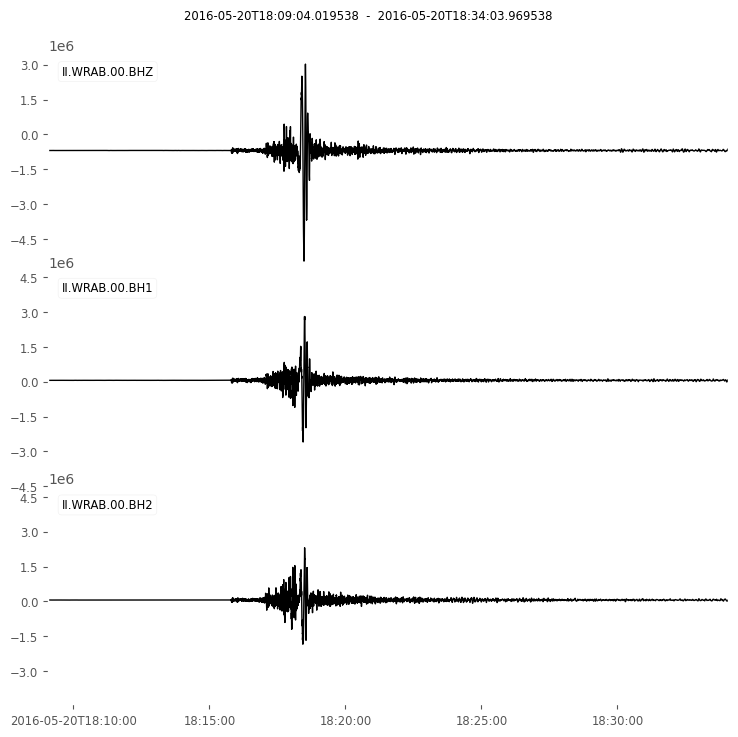

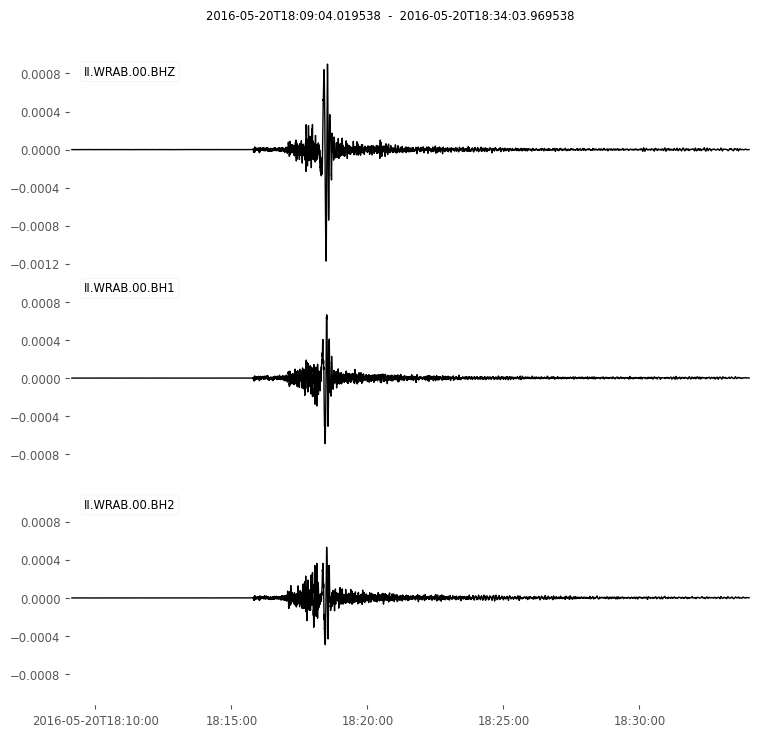

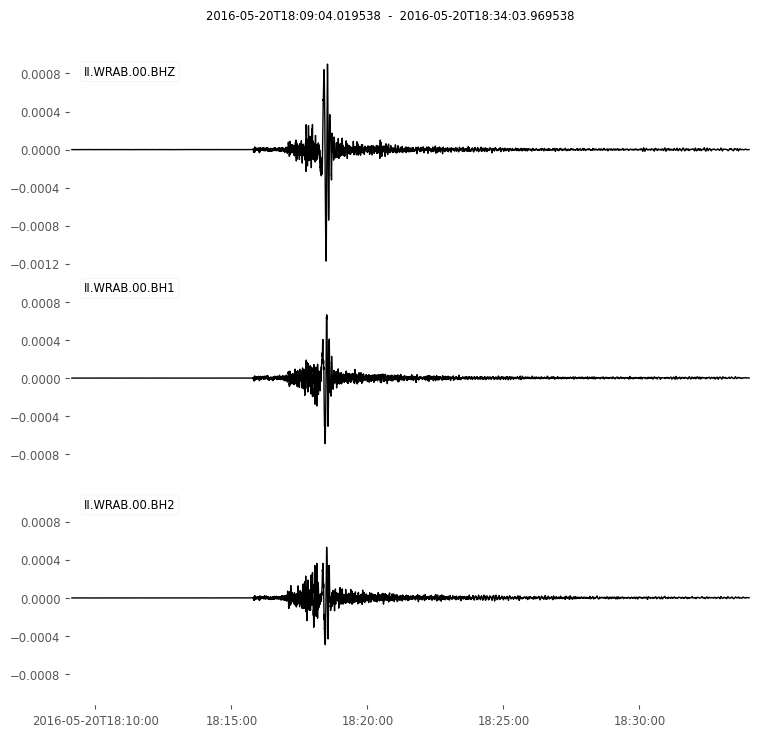

In [13]:
t = obspy.UTCDateTime("2016-05-20T18:14:04") # NT event Mww6.0
st = client.get_waveforms("II","WRAB","00","BH*", t - 5 * 60, t + 20 * 60)
inv = client.get_stations(network="II", station="WRAB", location="00", channel="BH*",
                          level="response", starttime=t - 10, endtime=t + 10)
st.plot()

st.remove_response(inventory=inv)
st.plot()

All data requested using the FDSN client can be directly saved to file using the **`filename="..."`** option. The data is then stored exactly as it is served by the data center, i.e. without first parsing by ObsPy and outputting by ObsPy.

In [19]:
import os
pngdir = './data'
if not os.path.exists(pngdir):
    os.makedirs(pngdir)
    
client.get_events(starttime=t-100, endtime=t+24*3600, minmagnitude=5,
                  filename="./data/requested_events.xml")
client.get_stations(network="II", station="WRAB", level="station",
                    filename="./data/requested_stations.xml")
client.get_waveforms("II", "WRAB", "00", "BH*", t - 10 * 60, t + 20 * 60,
                     filename="./data/requested_waveforms.mseed")
!ls -lrt data/*

-rw-r--r--. 1 nre900 z00   1481 Apr 16 17:10 data/requested_stations.xml
-rw-r--r--. 1 nre900 z00   2890 Apr 16 17:10 data/requested_events.xml
-rw-r--r--. 1 nre900 z00 217088 Apr 16 17:10 data/requested_waveforms.mseed


#### Plot up multiple waveforms

For each of these stations download data of the event, e.g. a couple of minutes before to half an hour after the event. Put all data together in one stream (put the `get_waveforms()` call in a try/except/pass block to silently skip stations that actually have no data available). Print stream info, plot the raw data.

2 Trace(s) in Stream:
II.WRAB.00.BHZ | 2016-05-20T18:09:04.019538Z - 2016-05-20T18:44:03.969538Z | 20.0 Hz, 42000 samples
II.WRAB.10.BHZ | 2016-05-20T18:09:04.019536Z - 2016-05-20T18:44:03.994536Z | 40.0 Hz, 84000 samples


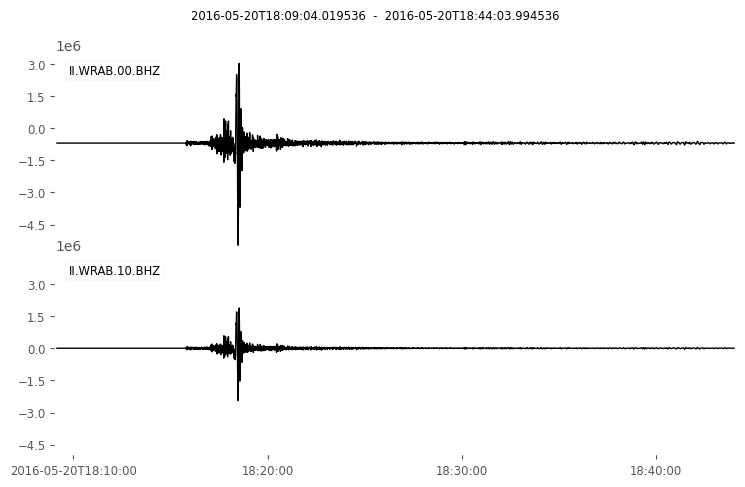

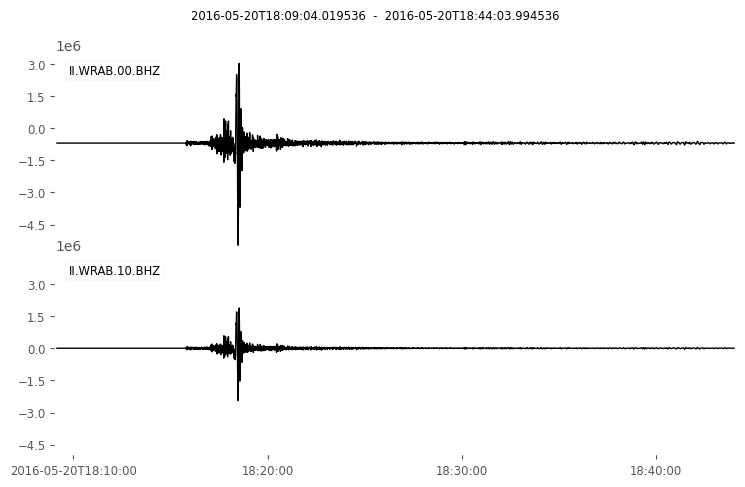

In [15]:
from obspy import Stream
st = Stream()

for network in inventory:
    for station in network:
        try:
            st += client.get_waveforms(network.code, station.code, "*", "BHZ",
                                       t - 5 * 60, t + 30 * 60)
        except:
            pass

print(st)
st.plot()